# Capstone

### Introduction etc etc

***
***

# Imports, Loading Data

In [1]:
#imports
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import re
import string
import seaborn as sns
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#models:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from keras.optimizers import SGD
from tensorflow.keras import preprocessing
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#seed for reproducible results
np.random.seed(42)
tf.random.set_seed(42)

##### explain datset in detail

In [2]:
data_dir_depression = './data/depression_dataset_reddit_cleaned.csv'

depression_df = pd.read_csv(data_dir_depression)

# EDA and Preprocessing

## Exploratory Data Analysis

In [3]:
#change to df for ease of use
df = depression_df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


In [4]:
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [5]:
df.isna().sum()

clean_text       0
is_depression    0
dtype: int64

In [6]:
df['is_depression'].value_counts()

0    3900
1    3831
Name: is_depression, dtype: int64

##### ______ discuss balance_____________________

In [7]:
# SHOW VISUALIZATION

In [8]:
df['islowercase'] = list(map(lambda x: x.islower(), df['clean_text']))
df['islowercase'].value_counts()

True    7731
Name: islowercase, dtype: int64

## Preprocessing Data

Explain __________________________________________________________________________________________

will create variations of columns to be able to experiment with different options (with/without stopwords, etc)

### Lowercase Text

In this case, the text data from the downloaded dataset is already lowercase, so we do not need to take this step!

In [9]:
# df['lower_text'] = df['clean_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# df['lower_text'].head()

### Tokenize
Explain __________________________________________________________________________________________

In [10]:
def tokenize_data(data):
    
    #(this regex code keeps words with apostrophes as single tokens)
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    
    #create tokens
    tokens = nltk.regexp_tokenize(data, pattern)
    return [word for word in tokens]

In [11]:
df['tokenized'] = df.apply(lambda x: tokenize_data(x['clean_text']), axis=1)
df['tokenized'].head()

0    [we, understand, that, most, people, who, repl...
1    [welcome, to, r, depression, s, check, in, pos...
2    [anyone, else, instead, of, sleeping, more, wh...
3    [i, ve, kind, of, stuffed, around, a, lot, in,...
4    [sleep, is, my, greatest, and, most, comfortin...
Name: tokenized, dtype: object

### Stopwords
Explain __________________________________________________________________________________________

In [12]:
#show top FreqDist of Tokenized Column
FreqDist(sum(df['tokenized'], [])).most_common(30)

[('i', 40411),
 ('to', 17965),
 ('and', 16326),
 ('a', 12638),
 ('the', 11932),
 ('my', 11430),
 ('it', 9976),
 ('of', 7738),
 ('t', 7698),
 ('me', 6941),
 ('that', 6506),
 ('in', 6088),
 ('m', 5758),
 ('but', 5427),
 ('is', 5324),
 ('for', 5196),
 ('have', 5007),
 ('this', 4557),
 ('just', 4527),
 ('so', 4337),
 ('s', 4073),
 ('with', 3869),
 ('wa', 3810),
 ('like', 3584),
 ('not', 3275),
 ('feel', 3227),
 ('can', 3217),
 ('be', 3158),
 ('on', 3075),
 ('don', 3029)]

In [13]:
stops = stopwords.words('english')

#add punctuation
for symbol in ",.'?!()":
    stops += symbol

    #show example of stopwords list
print(stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
def tokenize_remove_stops(data):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens = nltk.regexp_tokenize(data, pattern)
    return [word for word in tokens if word not in stops]

In [15]:
df['tokenized_no_stops'] = df.apply(lambda x: tokenize_remove_stops(x['clean_text']), axis=1)

#show difference
df[['tokenized','tokenized_no_stops']].head()

,tokenized,tokenized_no_stops
0,"[we, understand, that, most, people, who, repl...","[understand, people, reply, immediately, op, i..."
1,"[welcome, to, r, depression, s, check, in, pos...","[welcome, r, depression, check, post, place, t..."
2,"[anyone, else, instead, of, sleeping, more, wh...","[anyone, else, instead, sleeping, depressed, s..."
3,"[i, ve, kind, of, stuffed, around, a, lot, in,...","[kind, stuffed, around, lot, life, delaying, i..."
4,"[sleep, is, my, greatest, and, most, comfortin...","[sleep, greatest, comforting, escape, whenever..."


In [16]:
#show top FreqDist now that stopwords are removed!
freq_minus_stops = FreqDist(sum(df['tokenized_no_stops'], []))
freq_minus_stops.most_common(30)

[('wa', 3810),
 ('like', 3584),
 ('feel', 3227),
 ('get', 2316),
 ('want', 2292),
 ('know', 2283),
 ('life', 2147),
 ('time', 2069),
 ('even', 1812),
 ('day', 1688),
 ('people', 1660),
 ('really', 1617),
 ('depression', 1569),
 ('anxiety', 1548),
 ('thing', 1534),
 ('one', 1522),
 ('year', 1438),
 ('go', 1398),
 ('friend', 1297),
 ('would', 1285),
 ('think', 1280),
 ('going', 1252),
 ('ha', 1243),
 ('make', 1210),
 ('much', 1131),
 ('never', 1114),
 ('work', 1093),
 ('back', 1049),
 ('help', 1022),
 ('feeling', 948)]

##### explain wa, etc __________________________________________________________

##### show size diff _______________________________________________________

### Lemmatization
explain __________________________________________________________________________________________

In [17]:
lemmatizer = WordNetLemmatizer()

def lemmatize_data(data):
    return [lemmatizer.lemmatize(word) for word in data]

In [18]:
df['lemmatized_no_stops'] = df['tokenized_no_stops'].apply(lemmatize_data)
df['lemmatized_no_stops'].head()

0    [understand, people, reply, immediately, op, i...
1    [welcome, r, depression, check, post, place, t...
2    [anyone, else, instead, sleeping, depressed, s...
3    [kind, stuffed, around, lot, life, delaying, i...
4    [sleep, greatest, comforting, escape, whenever...
Name: lemmatized_no_stops, dtype: object

#### Rejoining Words
final step for later use, explain

In [19]:
def rejoin_words(column):
    return ( " ".join(column))

df['rejoined']= df.apply(lambda x: rejoin_words(x['lemmatized_no_stops']), axis=1)
df['rejoined']

0       understand people reply immediately op invitat...
1       welcome r depression check post place take mom...
2       anyone else instead sleeping depressed stay ni...
3       kind stuffed around lot life delaying inevitab...
4       sleep greatest comforting escape whenever wake...
                              ...                        
7726                                                 snow
7727                                 moulin rouge mad cry
7728                        trying shout find people list
7729    ughh find red sox hat got ta wear creepy nick ...
7730    slept wonderfully finally tried swatching new ...
Name: rejoined, Length: 7731, dtype: object

### The Peprocessed Dataset
##### explain _______________________________________

In [20]:
#show df minus the columns we dont need for this analysis
df[['clean_text', 'rejoined']].head()

,clean_text,rejoined
0,we understand that most people who reply immed...,understand people reply immediately op invitat...
1,welcome to r depression s check in post a plac...,welcome r depression check post place take mom...
2,anyone else instead of sleeping more when depr...,anyone else instead sleeping depressed stay ni...
3,i ve kind of stuffed around a lot in my life d...,kind stuffed around lot life delaying inevitab...
4,sleep is my greatest and most comforting escap...,sleep greatest comforting escape whenever wake...


#### Check for Significant Words in Corpus

specifically words that (to a human observer) may be dead giveaways for depression

In [21]:
#get 50 most common words from each class
depressed_top = FreqDist(sum(df['tokenized_no_stops'][df['is_depression']==1], [])).most_common(50)
undiag_top = FreqDist(sum(df['tokenized_no_stops'][df['is_depression']==0], [])).most_common(50)

In [22]:
depressed_top

[('wa', 3526),
 ('like', 3398),
 ('feel', 3115),
 ('know', 2153),
 ('want', 2135),
 ('life', 2109),
 ('get', 2084),
 ('time', 1908),
 ('even', 1751),
 ('people', 1603),
 ('depression', 1569),
 ('anxiety', 1545),
 ('really', 1480),
 ('thing', 1460),
 ('day', 1447),
 ('year', 1395),
 ('one', 1373),
 ('friend', 1249),
 ('would', 1224),
 ('go', 1183),
 ('think', 1180),
 ('make', 1132),
 ('ha', 1087),
 ('going', 1083),
 ('never', 1067),
 ('much', 1018),
 ('help', 985),
 ('back', 882),
 ('thought', 881),
 ('feeling', 878),
 ('work', 823),
 ('im', 814),
 ('way', 792),
 ('anything', 786),
 ('always', 765),
 ('everything', 765),
 ('anyone', 762),
 ('still', 747),
 ('something', 741),
 ('got', 732),
 ('every', 703),
 ('bad', 702),
 ('anymore', 701),
 ('also', 697),
 ('better', 690),
 ('see', 690),
 ('good', 689),
 ('could', 684),
 ('need', 667),
 ('someone', 646)]

In [23]:
for x in depressed_top:
    for y in undiag_top:
        if x[0] in y:
            depressed_top.remove(x)
depressed_top

[('like', 3398),
 ('know', 2153),
 ('life', 2109),
 ('time', 1908),
 ('even', 1751),
 ('people', 1603),
 ('depression', 1569),
 ('anxiety', 1545),
 ('thing', 1460),
 ('year', 1395),
 ('friend', 1249),
 ('would', 1224),
 ('think', 1180),
 ('make', 1132),
 ('going', 1083),
 ('never', 1067),
 ('help', 985),
 ('thought', 881),
 ('feeling', 878),
 ('im', 814),
 ('way', 792),
 ('anything', 786),
 ('always', 765),
 ('everything', 765),
 ('anyone', 762),
 ('something', 741),
 ('every', 703),
 ('anymore', 701),
 ('also', 697),
 ('better', 690),
 ('good', 689),
 ('could', 684),
 ('someone', 646)]

##### explanation _______________________________________________________

# Modeling

##### __EXPLAIN STARTING FEATURE CHOICE, TARGET, ETC__
## ____

what "simple data" means

also talk about data sizes

starting original

#### Splitting Data

In [73]:
X = df['clean_text']
y = df['is_depression']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### explain vectorizer

discuss max features

In [74]:
#max features 100 as a starting point
vectorizer = TfidfVectorizer(max_features=100)

X_train_vectorized = vectorizer.fit_transform(X_train)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=vectorizer.get_feature_names())

,about,all,always,am,an,and,anxiety,any,anyone,are,...,we,what,when,who,will,with,work,would,year,you
0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.538367,0.000000,0.451680,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2,0.188074,0.035935,0.049669,0.0,0.0,0.314132,0.042052,0.179436,0.000000,0.0,...,0.000000,0.075859,0.080886,0.047301,0.0,0.065732,0.0,0.044510,0.086666,0.036945
3,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.0,0.188034,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.346354,0.000000,0.287489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6179,0.000000,0.087283,0.000000,0.0,0.0,0.176076,0.000000,0.000000,0.000000,0.0,...,0.000000,0.092127,0.000000,0.000000,0.0,0.159657,0.0,0.000000,0.000000,0.000000
6180,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
6181,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.838652
6182,0.000000,0.000000,0.000000,0.0,0.0,0.242542,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000


### Metrics and Scoring
explain metric options

explain all in this context, but focus on acc, f1

ideal scores

## Baseline Model
explain model choice


In [75]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB, MultinomialNB
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression

In [76]:
nb_model = MultinomialNB()

baseline_cv = cross_val_score(nb_model, X_train_vectorized, y_train)
baseline_cv

array([0.8367017 , 0.82053355, 0.82295877, 0.82700081, 0.82281553])

##### explain cross val score, why its so high _______________________________________

In [77]:
#reminder that true values are balanced evenly:
y_train.value_counts(normalize=True)

0    0.504528
1    0.495472
Name: is_depression, dtype: float64

### Evaluate Model on Test Data

In [78]:
#fit model to train data
nb_model.fit(X_train_vectorized, y_train)

#vectorize test data
vectorizer = TfidfVectorizer(max_features=100)
X_test_vectorized = vectorizer.fit_transform(X_test)

#predict on test data
y_pred = nb_model.predict(X_test_vectorized)

In [79]:
# create confusion matrix helper function:
def plot_confusion(title, save_name):

    #confusion matrix for test data
    conf_matrix = confusion_matrix(y_test,y_pred)

    # plot confusion matrix values
    sns.heatmap(
    conf_matrix, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
    )

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)

    plt.savefig('./img/'+save_name+'.png')
    plt.show()

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67       780
           1       0.67      0.72      0.69       767

    accuracy                           0.68      1547
   macro avg       0.68      0.68      0.68      1547
weighted avg       0.68      0.68      0.68      1547



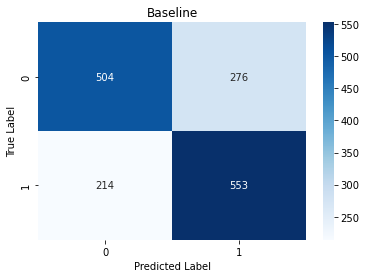

In [81]:
plot_confusion('Baseline', 'baseline')

##### explanation of results _____________________________________________________



##### coefficients etc ____________________________

In [82]:
coefficient_df = pd.DataFrame()
coefficient_df['feature'] = vectorizer.get_feature_names()
coefficient_df['coefficients'] = nb_model.coef_.T

#sort in descending order, to see which coefficient most affects the positive class prediction
coefficient_df.sort_values(by='coefficients', ascending=False)

C:\Users\shade\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


,feature,coefficients
5,anxiety,-3.163521
83,to,-3.189721
53,my,-3.515957
73,the,-3.525194
44,it,-3.557619
...,...,...
75,then,-5.486237
55,never,-5.491389
96,work,-5.491833
2,am,-5.517768


##### further detail about problematic "giveaway" words _______________________________________________________________________

look at again after stop words out of the way

##### explain min_df and max_df as well _________________________________________________

### Baseline Model with Preprocessed Data

explain

##### Rejoin Data _____________________________explain why_________________________________________________

for tfidf vectorizer

In [83]:
X = df['rejoined']
y = df['is_depression']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



##### explain pipeline ________________________________________________________

vectorizes as part of process

In [84]:
#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer(max_features=100)),
                          ('clf', MultinomialNB())
                         ])

#fit to data
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=100)),
                ('clf', MultinomialNB())])

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       780
           1       0.81      0.87      0.84       767

    accuracy                           0.83      1547
   macro avg       0.83      0.83      0.83      1547
weighted avg       0.83      0.83      0.83      1547



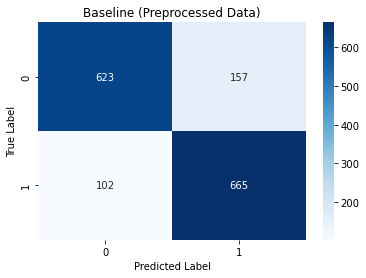

In [85]:
#predict on test data
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion('Baseline (Preprocessed Data)', 'base_2')

##### explain _________________________________---

identify how removal of stop words increased model performance

##### One more look at coefficients ______________________________________________________________

In [86]:
coefficient_df = pd.DataFrame()
coefficient_df['feature'] = pipe['vectorizer'].get_feature_names()
coefficient_df['coefficients'] = pipe['clf'].coef_.T

#sort in descending order, to see which coefficient most affects the positive class prediction
coefficient_df.sort_values(by='coefficients', ascending=False)[:20]

C:\Users\shade\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


,feature,coefficients
15,depression,-2.939940
50,like,-3.525742
26,feel,-3.591596
91,wa,-3.682812
2,anxiety,-3.728610
92,want,-3.906345
47,know,-3.907649
49,life,-3.918292
33,get,-3.955953
65,people,-4.053325


#### Attempt One More Time with Subjective Alterations

go over subjective nature, etc

In [87]:
#same as stopword removal but our own list
def remove_some_words(data):
    words = ['depression', 'feel', 'anxiety']
    return [word for word in data if word not in words]

In [88]:
#remove words from lemmatized dataset without stopwords
df['subjective_removal'] = df.apply(lambda x: remove_some_words(x['lemmatized_no_stops']), axis=1)\

#rejoin again for vectorizer!
df['rejoined_post_removal']= df.apply(lambda x: rejoin_words(x['subjective_removal']), axis=1)

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       780
           1       0.75      0.73      0.74       767

    accuracy                           0.74      1547
   macro avg       0.74      0.74      0.74      1547
weighted avg       0.74      0.74      0.74      1547



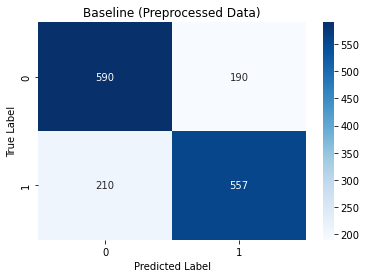

In [89]:
#repeat pipeline with new data
X = df['rejoined_post_removal']
y = df['is_depression']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer(max_features=100)),
                          ('clf', MultinomialNB())
                         ])

#fit to data
pipe.fit(X_train, y_train)

#predict on test data
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion('Baseline (Preprocessed Data)', 'base_2')

comment on scoring, slightly less accuract, etc 
##### __________

In [90]:
coefficient_df = pd.DataFrame()
coefficient_df['feature'] = pipe['vectorizer'].get_feature_names()
coefficient_df['coefficients'] = pipe['clf'].coef_.T

#sort in descending order, to see which coefficient most affects the positive class prediction
coefficient_df.sort_values(by='coefficients', ascending=False)[:20]

C:\Users\shade\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


,feature,coefficients
47,like,-3.416639
90,wa,-3.592212
44,know,-3.814494
91,want,-3.824219
46,life,-3.830649
30,get,-3.852510
62,people,-3.939920
84,time,-3.986497
18,even,-4.062245
61,one,-4.091224


## Model 2 - 

## Model 3 - 

## Model 4 - 

## Model 5 - 

## Model 6 - 

## Model 7 - 

gridsearch pipelines to choose model params

talk about word embeddings

rnn? implement at least a glimpse into neural networks